In [2]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-04-11 09:22:47--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-11 09:22:47--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [        <=>         ]  33.20M  6.82MB/s    in 14s     

2021-04-11 09:23:01 (2.40 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [3]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F
from collections import namedtuple
import matplotlib.pyplot as plt

Dataset = MNIST(root="./", transform=torchvision.transforms.ToTensor())
ValSplit = 0.2
TrainSZ, ValSZ = (int(len(Dataset) *( 1-ValSplit )), int(len(Dataset) * ValSplit))

TrainData, ValData = random_split(Dataset, (TrainSZ, ValSZ))

BatchSZ = 100
TrainLoader = DataLoader(TrainData, BatchSZ, shuffle= True)
ValLoader   = DataLoader(ValData, BatchSZ)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
ModelStats = namedtuple('ModelStats', ['Loss', 'Accuracy'])

class CNNModel(torch.nn.Module):
    def __init__(self, InputSZ, NClasses):
        super().__init__()
        self.InputSize  = InputSZ
        self.NumClasses = NClasses
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = torch.nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = torch.nn.Linear(3*3*64, 256)
        self.fc2 = torch.nn.Linear(256, NClasses)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return x
    
    def Accuracy(self, Out, lable):
        val, idx = torch.max(Out, dim = 1)
        return torch.tensor(torch.sum(idx == lable).item() / len(idx))
    
    def Step(self, Batch, Validation: bool):
        img, lbl = Batch
        
        img = img.to(device)
        lbl = lbl.to(device)

        out = self(img)
        loss = F.cross_entropy(out, lbl)
        if Validation:
            accuracy = self.Accuracy(out, lbl)
            return ModelStats(loss, accuracy)
        else:
            return loss
    
    def EndValidationEpoch(self, outputs):
        b_loss = [x.Loss for x in outputs]
        b_acc  = [x.Accuracy for x in outputs]

        e_loss = torch.mean(torch.stack(b_loss))
        e_acc  = torch.mean(torch.stack(b_acc))

        return ModelStats(e_loss.item(), e_acc.item())
    
    def EndEpoch(self, e, res):
        print(f"Epoch [{e}] Finished with Loss = {res.Loss:.4}, Accuracy = {(res.Accuracy * 100):.4}%")

def EvaluateModel(model, Loader):
    out = [model.Step(b, True) for b in Loader]
    return model.EndValidationEpoch(out)

def Fit(epochs, model, TrainLoader, ValLoader, opt):
    History = []
    for epoch in range(epochs):
        for batch in TrainLoader:
            loss = model.Step(batch, False)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        res = EvaluateModel(model, ValLoader)
        model.EndEpoch(epoch, res)
        History.append(res)
    
    return History





Epoch [0] Finished with Loss = 0.1403, Accuracy = 95.8%
Epoch [1] Finished with Loss = 0.09932, Accuracy = 97.01%
Epoch [2] Finished with Loss = 0.08803, Accuracy = 97.34%
Epoch [3] Finished with Loss = 0.07677, Accuracy = 97.7%
Epoch [4] Finished with Loss = 0.07751, Accuracy = 97.77%
Epoch [5] Finished with Loss = 0.07267, Accuracy = 97.97%
Epoch [6] Finished with Loss = 0.06025, Accuracy = 98.2%
Epoch [7] Finished with Loss = 0.06406, Accuracy = 98.1%
Epoch [8] Finished with Loss = 0.07733, Accuracy = 97.62%
Epoch [9] Finished with Loss = 0.058, Accuracy = 98.41%
Epoch [10] Finished with Loss = 0.0614, Accuracy = 98.41%
Epoch [11] Finished with Loss = 0.05824, Accuracy = 98.36%
Epoch [12] Finished with Loss = 0.05683, Accuracy = 98.46%
Epoch [13] Finished with Loss = 0.0531, Accuracy = 98.54%
Epoch [14] Finished with Loss = 0.05899, Accuracy = 98.28%


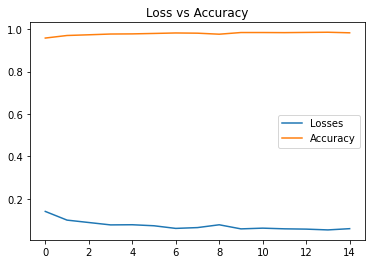

In [7]:
MODEL = CNNModel(28*28, 10)
MODEL.to(device)

LR = 0.001
MOMENTUM = 0.9
EPOCHS = 15
Optimizer = torch.optim.Adam(MODEL.parameters(), lr= LR)

Hist = Fit(EPOCHS, MODEL, TrainLoader, ValLoader, Optimizer)

Losses = [x.Loss for x in Hist]
Accs   = [x.Accuracy for x in Hist]

plt.plot(Losses, label= "Losses")
plt.plot(Accs, label= "Accuracy")
plt.title("Loss vs Accuracy")
plt.legend()
plt.show()

Model predicts 5, Truth = 5


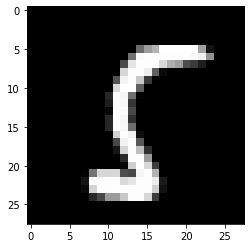

In [11]:
TestDataset= MNIST(root="./", train=False,transform=torchvision.transforms.ToTensor())

def Predict_Image(img, model, lbl):
    plt.imshow(img[0], cmap="gray")
    img = torch.unsqueeze(img, 0)
    img = img.to(device)
    out = model(img)
    _, prediction = torch.max(out, dim=1)
    print(f"Model predicts {prediction[0].item()}, Truth = {lbl}")

img, lbl = TestDataset[9870]
Predict_Image(img, MODEL, lbl)

In [13]:
TestLoader = DataLoader(TestDataset, 10, shuffle=True)
res = EvaluateModel(MODEL, TestLoader)
res

ModelStats(Loss=0.051950741559267044, Accuracy=0.9836000204086304)

In [15]:
import torch.onnx as onnx

torch.save(MODEL.state_dict(), "CNNModel.pt")

input_image = torch.zeros((1,1,28,28)).to(device)
onnx.export(MODEL, input_image, 'CNNModel.onnx')